In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations as cb

# 1 随机采样阵生成

In [3]:
# 随机采样阵生成
def randSamplingMatrix(m,N):
    """
    Return m*N sampling matrix.
    Use type `np.float16`.
    """
    
    #用高斯分布抽样并单位化.
    A = np.random.randn(m,N).astype(np.float32) # Suggest float32+ in accordance with np.linalg.
    A = A/np.sqrt(m)
    return A

# 2 Restricted Isometry Constant 估计

In [81]:
# RIP测试.
class RIPtest:
    def __init__(self,A,s):
        """
        Return possible delta_s given matrix `A` and sparsity `s`.

        Contain 2 methods:
            `RIPtest(A,s).monteCarlo(nVec,show)`: Monte Carlo method;
            `RIPtest(A,s).singularValue()`: singularValue method.
        """
        self.A = A
        self.s = s
    #         
    # 
    # 
    #                 
    # Monte-Carlo method.
    def monteCarlo(self, nVec=1e5, show=True): # 这是一个对象方法.
        # def fun() 是类方法; def fun(self) 是对象方法.
        """
        Return possible delta_s given matrix `A` and sparsity `s`. 
        `nVec`: Number of vectors to test. 
        `show`: Whether to draw the distribution of amplifications.

        Running time:
            O(nVec=10000,N=10000,m=400)~70sec;
            
            O(nVec=5000,N=5000,m=200)~10sec;

            O(nVec=100000,N=200,m=50)~3sec.
        """
        
        N = self.A.shape[1]
        nVec = int(nVec) # 转化形如`1e5`的输入.
        V =  np.zeros((N,nVec),order='F',dtype=np.float16) # 由多个s-稀疏的列向量组成. 
        Supps = np.array([np.random.choice(range(N),self.s,replace=False) for i in range(nVec)])
            # 随机抽取支集, 存为每一行.
        Entries = np.array([np.random.randn(self.s).astype(np.float16) for i in range(nVec)])
            # 随机赋予支集项的值, 存为每一行. 未正规化.
        for j in range(nVec):
            # supp = Supps[j]
            # entries = Entries[j]
            V[Supps[j],j] = Entries[j]/np.linalg.norm(Entries[j])
        V = np.dot(self.A,V)
            # 象.
        Amplifications = np.array(list(map(lambda v:np.linalg.norm(v), np.transpose(V))))
        ampMax = np.max(Amplifications); delta1 = ampMax-1
        ampMin = np.min(Amplifications); delta2 = 1-ampMin
        delta = max(delta1,delta2)

        if show==True:
        # 用Gaussian近似检测delta估计是否超出3-sigma,若是,则认为delta即使再估计也不会显著增加,基本准确.
            var = np.var(Amplifications)
            mean = np.mean(Amplifications)
            threeSigma = 3*np.sqrt(var)
            ThreeSigmaPoints = [mean - threeSigma, mean + threeSigma]
            Xnorm = np.linspace(ThreeSigmaPoints[0],ThreeSigmaPoints[1],100)
            Ynorm = stats.norm.pdf((Xnorm-mean)/np.sqrt(var))/np.sqrt(var)

            plt.hist(Amplifications,bins=100,density=True,label='Amplifications')
            plt.plot(Xnorm,Ynorm,'r:',label='Gaussian Reference')
            plt.axvline(ThreeSigmaPoints[0],linestyle='-.',color='g',label='-3 sigma')
            plt.axvline(ThreeSigmaPoints[1],linestyle='--',color='m',label='+3 sigma')
            plt.xlabel('Amp.')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            print("3-sigma points: [1 - {:}, 1 + {:}]".format(1-ThreeSigmaPoints[0],ThreeSigmaPoints[1]-1))
            
            if delta==delta1:
                side = 'Right'
            else:
                side = 'Left'
            print("Side:",side)
        return delta
    #
    #
    #
    # SingularValue method.
    def singularValue(self, showSingularValues=True, mode='memory-saving'):
        """
        Return delta_s.

        `showSingularValues`: Whether to show the two max&min singularValues of all submatrices.
        
        Running time:
            `mode='memory-saving'`: O(N=200,m=20,s=3)~30sec; O(N=2000,m=20,s=2)~39sec; O(N=2000,m=20,s=3)~ >5min.
            
            `mode='fast'`: O(N=200,m=20,s=3)~23sec; O(N=2000,m=20,s=2)~27sec; O(N=2000,m=20,s=3)~ >2min(MemoryError).
        
        建议:
            1, 采用分布式计算, 因为耗时关于s指数级增长;
            
            2, 改用Monte-Carlo方法, 其估计概率已足够大;
            
            3, `fast`模式对于稍大矩阵几乎不能用, 基本上会报错`MemoryError`.
        """
        
        N = self.A.shape[1]

        # 以时间换空间: 使用s个指针Pointers, 列举指针组合.
        if mode=='memory-saving':
            PtrCombinations = cb(range(N),self.s)
            maxSv, minSv = 1, 1
            for ptr in PtrCombinations:
                ptr = list(ptr)
                Svs = np.linalg.svd(self.A[:,ptr])[1] 
                    # `Svs` for 'Singular Values'.
                    # Only accept float32+ type.
                maxSv = max(np.max(Svs),maxSv)
                minSv = min(np.min(Svs),minSv)

        # ↑↓ 以空间换时间.
        elif mode=='fast':
            Submatrices = np.array(list(cb(self.A.transpose(),self.s)))

            # Svs = np.array(list(map(np.linalg.svd,
            #           Submatrices))).reshape(1,-1)[0]
            # ↑↓ Equivalent.
            Svs = np.linalg.svd(Submatrices)[1].reshape(1,-1)[0]

            maxSv = max(Svs)
            minSv = min(Svs)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta


# 3 硬阈值函数

In [7]:
# 硬阈值函数
def hardThreshold(x,s,T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    N = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0]=0 #去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1] #返回s-k个绝对最大值的索引.
        #这样的返回值不是标准的int64-type, 后续应转换.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(N)
    new[supp]=x[supp]

    return new

# 4 Iterative Hard Thresholding-PKS 函数

In [28]:
# IHT-PKS
def IHT_PKS(y,Phi,s,
    x0='zeroVector',T0=[],mu=0.9, # 学习率
    haltingRule=('relativeSampleErr',0.1),maxIteration=1000,xReal=None,suppReal=None,showPrecisionAndRecall=False):
    """
    Return a dict {
        estimate: estimate of the (nearly) s-sparse signal x where y=Phi*x,
        iterCount: iteration times,
        eps: halting l2-norm error bound (not squared) in terms of y,
        y: samples,
        errY: actual l2-norm error (not squared) in terms of y,
        relativeErrY: errY/|y|_2,
        confusion: confusion matrix
        }.
    Print a message if reaching maxIteration.

    `y`: Sample vector.
    `Phi`: Sensing matrix.
    `s`: Sparsity of signal x.
    `x0`: (Optional) Initial estimate for x of iteration. Can receive a vector.
    `T0`: (Optional) Prior support of x.
    `mu`: (Optional) Learning rate.
    `haltingRule`: (Optional) By default ('relativeSampleErr',0.1), which halts the iteration when `|y-Phi*x|/|y|<0.1`. 
    `maxIteration`: (Optional) Halt when iterating these many times.
    `xReal`: (Optional) Real x.
    `suppReal`: (Optional) Real supp(x), or if x is compressible then by default the largest `s` atoms of x, unless otherwise stated.
    `showPrecisionAndRecall`: (Optional) Whether to print precision & recall.
    """

    # Initialize
    N = Phi.shape[1]

    if x0=='zeroVector':
        x0 = np.zeros(N)
    haltingRule,eps = haltingRule[0],haltingRule[1]
    PhiTrans = Phi.transpose()
    yNorm = np.linalg.norm(y)
    if haltingRule=='relativeSampleErr':
        eps = eps*yNorm #转换为停机的绝对误差限.
    else:
        print('(20230112)暂未配置其他停机规则,无返回.')
        return

    # Iterate
    for t in range(0,maxIteration):
        proxy = x0 + mu*np.dot(PhiTrans,(y-np.dot(Phi,x0))) #矩阵相乘用np.dot().
        x1 = hardThreshold(proxy,s,T0)
        err = np.linalg.norm(y-np.dot(Phi,x1))
        iterCount = t+1

        if err<eps:
            break
        x0 = x1
    else: #达到最大迭代次数, 停机.
        print('Reach maxIteration!')

    if any(xReal):
        if suppReal is None:
            suppReal = np.argsort(xReal)[:-(s+1):-1] #兼容compressible signal.
        
        # Compute confusion matrix.
        nPositive = np.sum(x1!=0)
        nTruePositive = np.sum(x1[suppReal]!=0)
        nFalsePositive = nPositive - nTruePositive
        nNegative = N - nPositive
        nFalseNegative = np.sum(x1[suppReal]==0)
        nTrueNegative = nNegative - nFalseNegative

        confusion = pd.DataFrame(np.array([
            [nTruePositive,nTrueNegative],
            [nFalsePositive,nFalseNegative]
        ]), columns=['positive','negative'],index=['true','false'])
        if showPrecisionAndRecall == True:
            print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
            print('recall:',nTruePositive/(nTruePositive + nFalseNegative))
    
    else:
        confusion = None
    return dict(
        estimate=x1,
        iterCount=iterCount,
        eps=eps,
        y=y,
        errY=err,
        relativeErrY=err/yNorm,
        confusion=confusion
    )


# 数值测试

C in O(slog(N/s)) 测试.

In [ ]:
# C系数测试

def numTest(x=np.array([0,3,0,0,4,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,0,0,0,0,4,0,
        6,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2]),
    C=1):
    """Print N,s, as well as m, depending on (C,N,s).
    Return an experiment dict object.
    
    :param x: Real signal
    :param C: Coefficient in O(slog(N/s)).
    """

    N=len(x)
    s=len(np.nonzero(x)[0])
    m=int(C*s*np.log(N/s))
    Phi=randSamplingMatrix(m,N)
    
    y=np.dot(Phi,x)

    print('N=',N,';s=',s,';m=',m)
    return IHT_PKS(y,Phi,s,N,xReal=x)

In [ ]:
np.random.seed(42)
numTest(C=5)

# Debug region

In [70]:
np.random.seed(42)
A = randSamplingMatrix(50,200)

In [41]:
x = np.array([1,1,2,2,1,0,8,6,5,3,7,0])
x = np.append(x,np.zeros(2000-12))

In [71]:
RIPtest(A,3).singularValue()

Max singular value: 1.519878
Min singular value: 0.5290351


0.5198780298233032

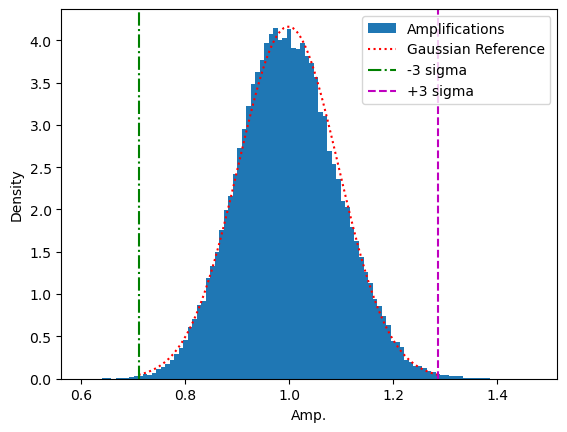

3-sigma points: [1 - 0.28908221423625946, 1 + 0.2860357016324997]
Side: Right


0.4718129634857178

In [79]:
np.random.seed(42)
RIPtest(A,3).monteCarlo(nVec=1e5)

In [37]:
# IHT:
result = IHT_PKS(np.dot(A,x),A,10,xReal=x,showPrecisionAndRecall=True)

precision: 1.0
recall: 1.0


In [27]:
Submatrices = np.array(list(cb(A.transpose(),3)))

In [42]:
Submatrices = np.array(list(cb(A.transpose(),3)))
Svs = np.array(list(map(lambda X: np.linalg.svd(X)[1],
            Submatrices))).reshape(1,-1)[0]


In [47]:
len(Svs.reshape(1,-1)[0])

3940200

In [17]:
a.reshape(1,-1)[0]

array([1. , 1.1, 1.2, 2. , 2.1, 2.2])

In [18]:
max([1,2])

2